# Explorer les données d'OpenFoodFacts

Nous allons explorer le jeu de données d'OpenFoodFacts, filtré pour ne conserver que les produits vendus en France et les champs remplis pour au moins 1000 produits, dont les fiches sont marquées "complètes" et contiennent un nom de produit et une marque.

In [1]:
import pandas as pd

In [2]:
# modifier le chemin vers le fichier CSV si nécessaire
# ici on utilise le fichier filtré dans le notebook précédent
CSV_FILE = '../data/off_subset.csv'

In [5]:
# on charge les types de données qu'on a spécifiés dans le notebook 1
DTYPE_FILE = '../data/dtype.txt'
with open(DTYPE_FILE) as f:
    dtype = eval(f.read())

In [6]:
df_off = pd.read_csv(CSV_FILE, sep='\t', dtype=dtype)
df_off.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90738 entries, 0 to 90737
Columns: 101 entries, code to nutrition-score-uk_100g
dtypes: category(18), float16(44), int64(2), object(37)
memory usage: 337.0 MB


## Exploration et nettoyage avec OpenRefine

La méthode la plus simple pour explorer le contenu du jeu de données est d'utiliser un outil graphique comme OpenRefine, qui permet aussi et surtout de nettoyer un jeu de données de façon reproductible.

### Présentation et installation d'OpenRefine

OpenRefine est un outil graphique, open source, pour travailler sur des jeux de données sales.
Cet outil permet de nettoyer un jeu de données de façon semi-automatique, par itérations successives.
OpenRefine stocke l'historique des opérations de nettoyage que vous appliquez et vous permet de l'exporter pour le rejouer, sur le même jeu de données ou sur une autre version de ce jeu de données.

Je vous conseille de visionner les 3 captures vidéo de la documentation officielle, qui donne une bonne idée de ce que vous pouvez réaliser avec OpenRefine.
https://github.com/OpenRefine/OpenRefine/wiki/Screencasts

Vous pouvez télécharger OpenRefine depuis cette page :
https://openrefine.org/download.html

### Lancement d'OpenRefine
Une fois que vous avez téléchargé et installé OpenRefine, vous pouvez ouvrir le fichier CSV filtré (tous les produits d'OpenFoodFacts distribués en France, restreint aux colonnes contenant plus de 1000 valeurs).

Par défaut, OpenRefine s'alloue 1 Go de RAM, ce qui est insuffisant pour notre fichier.
Il y a deux solutions:
1. Allouer plus de RAM pour ouvrir le fichier ;
2. Exporter en CSV un sous-ensemble plus restreint du jeu de données, contenant moins de lignes ou moins de colonnes.

#### Option 1: Allouer plus de RAM
On modifie les paramètres de lancement d'OpenRefine: https://github.com/OpenRefine/OpenRefine/wiki/FAQ:-Allocate-More-Memory

Par exemple :
```sh
# 4096 Mo = 4 Go de RAM
./refine -m 4096m
```

#### Option 2: Exporter un sous-ensemble du jeu de données
Nous allons exporter une fraction de l'ensemble de produits, par exemple les 900 premières fiches de produits laitiers ('en:dairies').

In [7]:
# on prend les 900 premières fiches
df_sub = df_off[df_off['categories_tags'].str.contains('en:dairies')][:900]
print(df_sub.shape)
# on fait un dump CSV du jeu de données filtré
SEL_FILE = '../data/off_small.csv'
df_sub.to_csv(SEL_FILE, sep='\t', index=False)

(900, 101)


### Utilisation d'OpenRefine

Ouvrir le fichier.

Dans la fenêtre de configuration des options de parsing:
- vérifier que le séparateur (tab), la ligne d'en-tête... sont correctement détectés ;
- cocher la case "Parse cell text into numbers, dates..." pour mieux visualiser et manipuler ces types de données ;
- appuyer sur "create project" (en haut à droite).

L'import des données ne prend normalement que quelques secondes.
Si le temps d'import estimé augmente et se compte en minutes, c'est que vous n'avez pas alloué suffisamment de RAM ou que vous essayez de charger un fichier trop gros (retour à l'option 1 ou 2 ci-dessus).

Nous pouvons créer une facette pour examiner une colonne, par exemple la colonne contenant les marques.

La facette met en évidence que parmi les plus de 60000 valeurs distinctes se trouvent de nombreuses variantes graphiques de la même marque.
L'utilisation d'une méthode de clustering dans une facette permet de regrouper et fusionner ces variantes par paquets.

Par exemple, combien y a-t-il de variantes pour la marque "Nos régions ont du talent, Leclerc" ?

Quelles sont les informations disponibles pour chaque cluster ?

Pour la méthode de clustering "key collision":
- Quelles "keying functions" sont disponibles?
- Comment fonctionnent-elles?
- Produisent-elles des clusterings similaires?
- Pourquoi?

## Exploration avec dirty_cat

```sh
# quand la version 0.0.6 sera sortie:
# pip install --user dirty_cat
# en attendant on installe depuis la pointe de la branche sur le dépôt github
pip install --user -U git+git://github.com/dirty-cat/dirty_cat.git#egg=dirty_cat
```

https://dirty-cat.github.io/stable/auto_examples/01_investigating_dirty_categories.html

In [8]:
df_sub['product_name'].value_counts().sort_index()

0% fat Greek style yogurt               1
10 tranches Emmental français           1
12 petits fromages de chèvre doux       1
2 Clotted Cream Rice Puddings           1
4 chèvre chauds                         1
                                       ..
yaourt 0,1% myrtille                    1
yaourt au lait de brebis                1
yaourt aux fruits                       1
yaourt bio au lait de brebis nature.    1
yaourt nature                           1
Name: product_name, Length: 795, dtype: int64

In [9]:
sorted_values = df_sub['product_name'].sort_values().unique()

In [10]:
from dirty_cat import SimilarityEncoder

similarity_encoder = SimilarityEncoder(similarity='ngram')
transformed_values = similarity_encoder.fit_transform(
    sorted_values.reshape(-1, 1))
transformed_values.shape

(795, 795)

Pour mieux comprendre la représentation créée par l'encodeur de similarité, nous pouvons afficher quelques noms de produits sur un graphe en 2 dimensions (en utilisant une méthode de réduction de dimensionalité!).

In [11]:
from sklearn.manifold import MDS

mds = MDS(dissimilarity='precomputed', n_init=10, random_state=42)
two_dim_data = mds.fit_transform(
    1 - transformed_values)  # transformed values lie
# in the 0-1 range, so 1-transformed_value yields a positive dissimilarity matrix
print(two_dim_data.shape)
print(sorted_values.shape)

(795, 2)
(795,)


On ajuste un modèle de k plus proches voisins (kNN) pour éviter de surcharger le graphe.

In [12]:
import numpy as np

n_points = 5
np.random.seed(43)
from sklearn.neighbors import NearestNeighbors

random_points = np.random.choice(len(similarity_encoder.categories_[0]),
                                 n_points, replace=False)
nn = NearestNeighbors(n_neighbors=2).fit(transformed_values)
_, indices_ = nn.kneighbors(transformed_values[random_points])
indices = np.unique(indices_.squeeze())

Puis on dessine le graphe en ajoutant les catégories de départ (ici les noms de produits).

Text(0.5, 1.0, 'multi-dimensional-scaling representation using a 3gram similarity matrix')

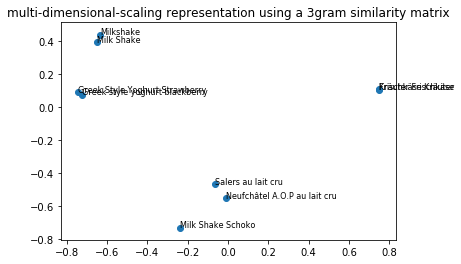

In [13]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.scatter(x=two_dim_data[indices, 0], y=two_dim_data[indices, 1])
# adding the legend
for x in indices:
    ax.text(x=two_dim_data[x, 0], y=two_dim_data[x, 1], s=sorted_values[x],
            fontsize=8)
ax.set_title(
    'multi-dimensional-scaling representation using a 3gram similarity matrix')

### Heatmap de la matrice de similarité

Nous pouvons afficher la matrice de similarité pour ces observations.

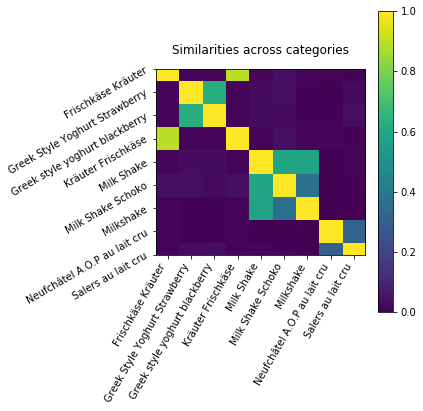

In [14]:
f2, ax2 = plt.subplots(figsize=(6, 6))
cax2 = ax2.matshow(transformed_values[indices, :][:, indices])
ax2.set_yticks(np.arange(len(indices)))
ax2.set_xticks(np.arange(len(indices)))
ax2.set_yticklabels(sorted_values[indices], rotation='30')
ax2.set_xticklabels(sorted_values[indices], rotation='60', ha='right')
ax2.xaxis.tick_bottom()
ax2.set_title('Similarities across categories')
f2.colorbar(cax2)
f2.tight_layout()

## Geopandas

Le champ `first_packaging_code_geo` contient des coordonnées géographiques.

Il est donc possible de dessiner une carte avec `geopandas`:
https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

In [5]:
# TODO dessiner une carte à partir de first_packaging_code_geo

## Exploration par facettes liées ?

https://seaborn.pydata.org/tutorial/relational.html#showing-multiple-relationships-with-facets

## Réduction de dimensionalité

Nous utiliserons une implémentation efficace de t-SNE: [openTSNE](https://github.com/pavlin-policar/openTSNE/).

```sh
conda install --channel conda-forge opentsne
```

Nous allons maintenant comparer les produits laitiers selon leurs valeurs nutritionnelles.

Le [système des feux tricolores](https://fr.openfoodfacts.org/reperes-nutritionnels) repose sur l'affichage de 4 valeurs nutritionnelles:
* gras,
* graisses saturées,
* sucres,
* sel

Nous allons chercher à faire émerger une structure sur l'ensemble des produits laitiers dans l'espace à 4 dimensions formé par ces valeurs nutritionnelles, en utilisant le [Nutri-Score](https://fr.wikipedia.org/wiki/Nutri-score) comme point de comparaison.

In [49]:
# on reprend l'ensemble des produits laitiers (fiches complètes)
df_dairies = df_off[df_off['categories_tags'].str.contains('en:dairies')]
df_dairies

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,cocoa_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000491228,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1543690964,2018-12-01T19:02:44Z,1543692731,2018-12-01T19:32:11Z,Entremets Crème Brulée,NaN,20 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0
40,00013029,http://world-en.openfoodfacts.org/product/0001...,beniben,1494672859,2017-05-13T10:54:19Z,1494674596,2017-05-13T11:23:16Z,Cheddar,Cheddar en tranches,"7.788 kg (6 * 1,298 kg)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,00073899,http://world-en.openfoodfacts.org/product/0007...,teolemon,1488619049,2017-03-04T09:17:29Z,1574080183,2019-11-18T12:29:43Z,Cornish Cove Cheddar,Fromage cheddar au lait pasteurisé avec du pim...,200 g e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,20.0
69,00078115,http://world-en.openfoodfacts.org/product/0007...,beniben,1474487030,2016-09-21T19:43:50Z,1574091724,2019-11-18T15:42:04Z,Mild Cheddar with Onions & Chives,Fromage cheddar en tranches avec des oignons e...,160 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,20.0
172,16229005115,http://world-en.openfoodfacts.org/product/0016...,kiliweb,1517775503,2018-02-04T20:18:23Z,1560376995,2019-06-12T22:03:15Z,"Aroy-d Flavored Milk (coconut Milk, 400 Ml)",NaN,400 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90657,9415522001823,http://world-en.openfoodfacts.org/product/9415...,reva94,1500574490,2017-07-20T18:14:50Z,1561608391,2019-06-27T04:06:31Z,Lait entier en poudre,Lait entier en poudre,800 g,...,0.950195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90658,9415522285001,http://world-en.openfoodfacts.org/product/9415...,kiliweb,1526815887,2018-05-20T11:31:27Z,1573934713,2019-11-16T20:05:13Z,Meadow Fresh Pure Milk Full Cream,lait entier,1 l,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0
90659,94155877,http://world-en.openfoodfacts.org/product/9415...,openfoodfacts-contributors,1428711437,2015-04-11T00:17:17Z,1565325930,2019-08-09T04:45:30Z,Lite Milk,NaN,1 l.,...,0.300049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0
90663,9421017551575,http://world-en.openfoodfacts.org/product/9421...,openfoodfacts-contributors,1417639309,2014-12-03T20:41:49Z,1561640317,2019-06-27T12:58:37Z,Passion Fruit Live Gourmet Yoghurt,Yoghurt with fruit - sweetened,500 g,...,NaN,NaN,NaN,NaN,3.199219,NaN,NaN,NaN,7.0,7.0


In [52]:
# le système de feux tricolores repose sur l'affichage de 4 valeurs nutritionnelles:
# matières grasses, acides gras saturés, sucres, sel
cols_tl = ['fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g']
col_y = 'nutriscore_grade'
# on ne garde que les lignes où les 5 données nécessaires sont renseignées
df_dairies.dropna(axis=0, how='any', subset=[col_y], inplace=True)
x_tl = df_dairies[cols_tl].fillna(0)
y = df_dairies[col_y]
y

/home/mathieu/miniconda3/envs/off-explore/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1        b
68       d
69       d
172      d
190      a
        ..
90656    a
90658    d
90659    a
90663    c
90672    c
Name: nutriscore_grade, Length: 9117, dtype: category
Categories (5, object): [a, b, c, d, e]

In [ ]:
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

In [53]:
tsne = TSNE(perplexity=30, metric='euclidean', callbacks=ErrorLogger(), n_jobs=-2, random_state=42)

In [54]:
emb_x_tl = tsne.fit(x_tl)

/home/mathieu/.local/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteration   50, KL divergence  4.3778, 50 iterations in 0.6307 sec
Iteration  100, KL divergence  3.4472, 50 iterations in 0.6517 sec
Iteration  150, KL divergence  3.1552, 50 iterations in 0.6538 sec
Iteration  200, KL divergence  2.9985, 50 iterations in 0.6692 sec
Iteration  250, KL divergence  2.8999, 50 iterations in 0.6815 sec
Iteration   50, KL divergence  2.1551, 50 iterations in 0.6639 sec
Iteration  100, KL divergence  1.7251, 50 iterations in 0.6528 sec
Iteration  150, KL divergence  1.4489, 50 iterations in 0.6504 sec
Iteration  200, KL divergence  1.2584, 50 iterations in 0.8284 sec
Iteration  250, KL divergence  1.1249, 50 iterations in 1.0638 sec
Iteration  300, KL divergence  1.0318, 50 iterations in 1.3621 sec
Iteration  350, KL divergence  0.9674, 50 iterations in 1.5486 sec
Iteration  400, KL divergence  0.9149, 50 iterations in 1.7282 sec
Iteration  450, KL divergence  0.8804, 50 iterations in 1.8748 sec
Iteration  500, KL divergence  0.8527, 50 iterations in 2.4510

In [56]:
# couleurs du Nutri-Score
colors_nutriscore = {
    'a': "#058244",
    'b': "#85BD39",
    'c': "#FDCD2A",
    'd': "#ED831E",
    'e': "#E53F1A",
}

# c/c openTSNE.examples.utils.plot()
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

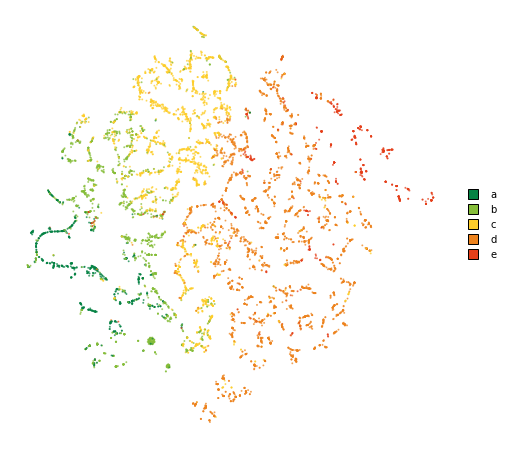

In [57]:
plot(emb_x_tl, y, colors=colors_nutriscore)

Le calcul du Nutri-Score se base sur :
* positif :
  - énergie,
  - graisses saturées,
  - sucres,
  - sels,
* négatif :
  - proportion de fruits, légumes et noix,
  - fibres,
  - protéines
  
Essayons de calculer une structure dans l'espace à 7 dimensions correspondant, et voyons si cette structure est mieux corrélée au Nutri-Score.

In [67]:
cols_ns = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g',
           'proteins_100g']
# 'fruits-vegetables-nuts-estimate_100g', 'fiber_100g' ne sont pas assez renseignés
print(df_dairies[cols_ns].count())
x_ns = df_dairies[cols_ns].fillna(0)
y = df_dairies[col_y]
y

energy_100g           9117
saturated-fat_100g    9117
sugars_100g           9117
salt_100g             9117
proteins_100g         9117
dtype: int64


1        b
68       d
69       d
172      d
190      a
        ..
90656    a
90658    d
90659    a
90663    c
90672    c
Name: nutriscore_grade, Length: 9117, dtype: category
Categories (5, object): [a, b, c, d, e]

In [68]:
tsne = TSNE(perplexity=30, metric='euclidean', callbacks=ErrorLogger(), n_jobs=-2, random_state=42)

In [69]:
emb_ns = tsne.fit(x_ns)

/home/mathieu/.local/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteration   50, KL divergence  4.7148, 50 iterations in 0.5680 sec
Iteration  100, KL divergence  3.4660, 50 iterations in 0.6636 sec
Iteration  150, KL divergence  3.0163, 50 iterations in 0.6519 sec
Iteration  200, KL divergence  2.7865, 50 iterations in 0.6485 sec
Iteration  250, KL divergence  2.6409, 50 iterations in 0.5935 sec
Iteration   50, KL divergence  2.0241, 50 iterations in 0.5691 sec
Iteration  100, KL divergence  1.6173, 50 iterations in 0.6095 sec
Iteration  150, KL divergence  1.3495, 50 iterations in 0.6129 sec
Iteration  200, KL divergence  1.1597, 50 iterations in 0.8160 sec
Iteration  250, KL divergence  1.0311, 50 iterations in 1.0948 sec
Iteration  300, KL divergence  0.9408, 50 iterations in 1.3340 sec
Iteration  350, KL divergence  0.8729, 50 iterations in 1.7232 sec
Iteration  400, KL divergence  0.8298, 50 iterations in 1.9838 sec
Iteration  450, KL divergence  0.7986, 50 iterations in 2.2262 sec
Iteration  500, KL divergence  0.7747, 50 iterations in 2.8150

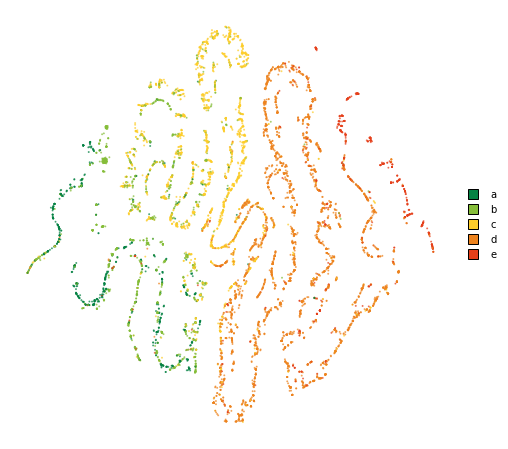

In [70]:
plot(emb_ns, y, colors=colors_nutriscore)

Dans le graphe ci-dessus, la couleur représente une catégorie Nutri-Score.

Nous pouvons également utiliser la couleur pour montrer les catégories de produits.

In [78]:
y_cheeses = df_dairies['categories_tags'].str.contains('en:cheeses')
y_cheeses.value_counts()

False    5087
True     4030
Name: categories_tags, dtype: int64

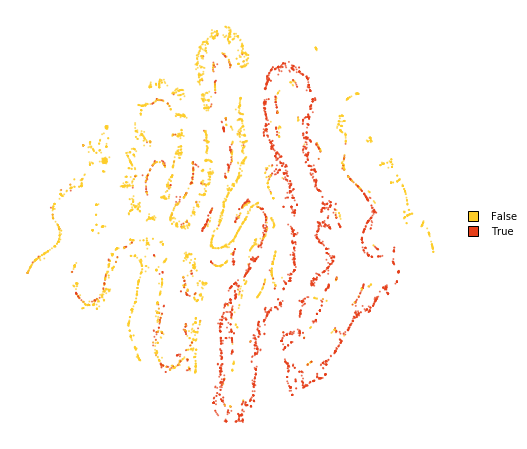

In [79]:
colors_bool = {
    False: "#FDCD2A",
    True: "#E53F1A",
}
plot(emb_ns, y_cheeses, colors=colors_bool)

In [80]:
y_crd = df_dairies['categories_tags'].str.contains('en:dessert-creams')
y_crd.value_counts()

False    8733
True      384
Name: categories_tags, dtype: int64

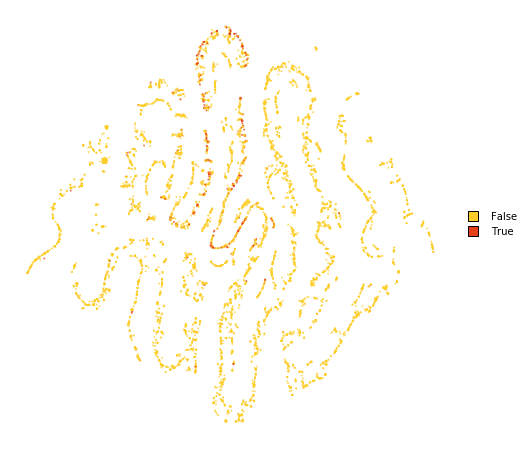

In [85]:
plot(emb_ns, y_crd, colors=colors_bool)

In [84]:
y_desserts = df_dairies['categories_tags'].str.contains('en:dessert')
y_desserts.value_counts()

False    7300
True     1817
Name: categories_tags, dtype: int64

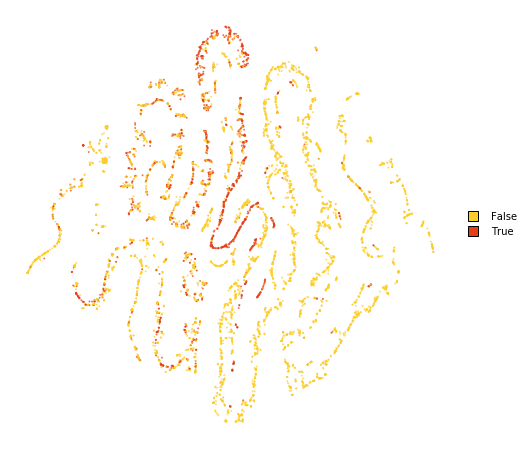

In [87]:
plot(emb_ns, y_desserts, colors=colors_bool)

In [91]:
y_crms = df_dairies['categories_tags'].str.contains('en:creams')
y_crms.value_counts()

False    8744
True      373
Name: categories_tags, dtype: int64

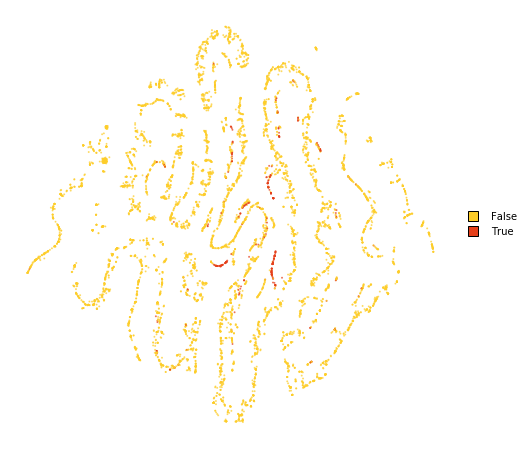

In [92]:
plot(emb_ns, y_crms, colors=colors_bool)